In [18]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

In [20]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


In [21]:
pd.options.display.max_columns=21
df

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688505,2018-2-UK01-KA125-048625,2018-19,2018-09,2019-07,319,Individual Volunteering Activities,???,ES,??? - ???,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
688506,2018-2-UK01-KA125-048626,2018-19,2018-10,2019-03,137,Individual Volunteering Activities,???,ES,??? - ???,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688507,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-04,170,Individual Volunteering Activities,???,CZ,??? - ???,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688508,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-10,351,Individual Volunteering Activities,???,FR,??? - ???,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [22]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 14, 6))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))
print((mobility_df['Field of Education'].nunique())) 


3759
4264
141


In [23]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df


Number of Receiving Universities:  3668
Number of Sending Universities:  4189


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending Country Code,Field of Education
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,AT,Music and performing arts
195,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,UA,Environmental protection technology
196,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,UA,Electronics and automation
197,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,UA,Mechanics and metal trades
198,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,AT,Mining and extraction
...,...,...,...,...,...,...
667190,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...,UK,Political sciences and civics
667191,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...,UK,Political sciences and civics
667192,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,Student mobility for Studies To/From Partner C...,RU,Economics
667193,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,Student mobility for Studies To/From Partner C...,UK,"Arts and humanities, inter-disciplinary progra..."


In [24]:
field_df = mobility_df.iloc[:,[5,2]].groupby(['Field of Education']).sum()
field_df.sort_values(by='Participants', inplace=True)
field_df

,Participants
Field of Education,
Education,1
Manufacturing and processing,2
"Natural sciences, mathematics and statistics",2
"Hygiene and occupational health services, not elsewhere classified",2
"Fisheries, not elsewhere classified",3
...,...
Political sciences and civics,10388
"Engineering and engineering trades, not further defined",10790
Law,13951


In [25]:
node_df = mobility_df.iloc[:, [0,4]].groupby(['Sending Organization', 'Sending Country Code']).sum()
node_df.to_csv('nodes_universities.csv')
mob_df = mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1)
edges_df = mob_df.iloc[:,[0,1,2] ].groupby(['source', 'target']).sum()
edges_df
edges_df.to_csv('edges_universities.csv')
node_df

,
Sending Organization,Sending Country Code
"""ADA"" UNIVERSITY",AZ
"""FINANCIAL ACADEMY""",KZ
"""KATHOLISCHE STIFTUNGSHOCHSCHULE MÜNCHEN"" HOCHSCHULE FÜR ANGEWANDTE WISSENSCHAFTEN DER KIRCHLICHEN STIFTUNG DES ÖFFENTLICHEN RECHTS ""KATHOLISCHE BILDUNGSSTÄTTEN FÜR SOZIALBERUFE IN BAYERN""",DE
"""KROK"" UNIVERSITY",UA
''FRENCH UNIVERSITY IN ARMENIA'' FOUNDATION,AM
...,...
ÜSKÜDAR UNIVERSITY,TR
РОССИЙСКАЯ АКАДЕМИЯ НАРОДНОГО ХОЗЯЙСТВА И ГОСУДАРСТВЕННОЙ СЛУЖБЫ ПРИ ПРЕЗИДЕНТЕ РОССИЙСКОЙ ФЕДЕРАЦИИ,RU
РОССИЙСКИЙ ГОСУДАРСТВЕННЫЙ АГРАРНЫЙ УНИВЕРСИТЕТ - МСХА ИМЕНИ К.А. ТИМИРЯЗЕВА,RU


In [26]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

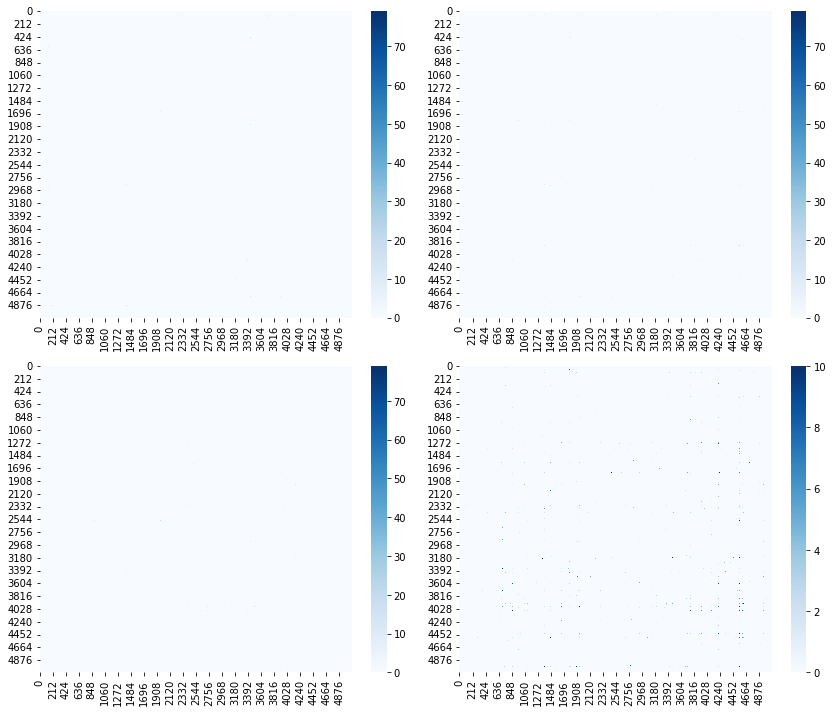

In [27]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
ns.visualize_adj(adj_matrix_crs)

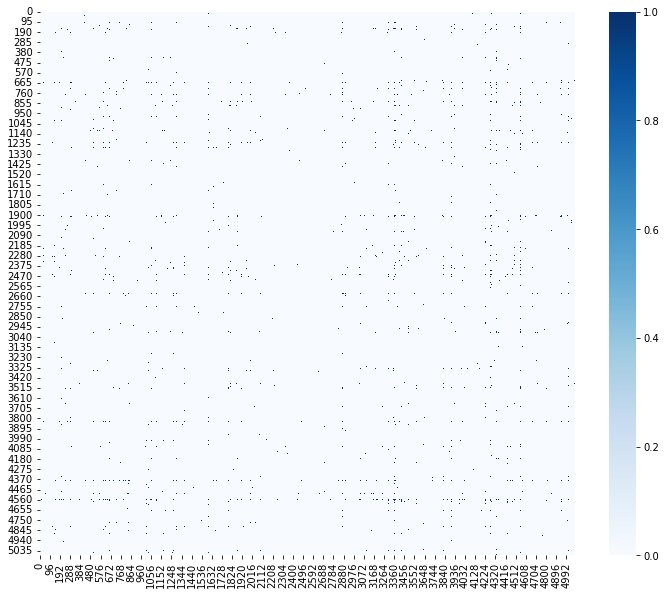

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [29]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

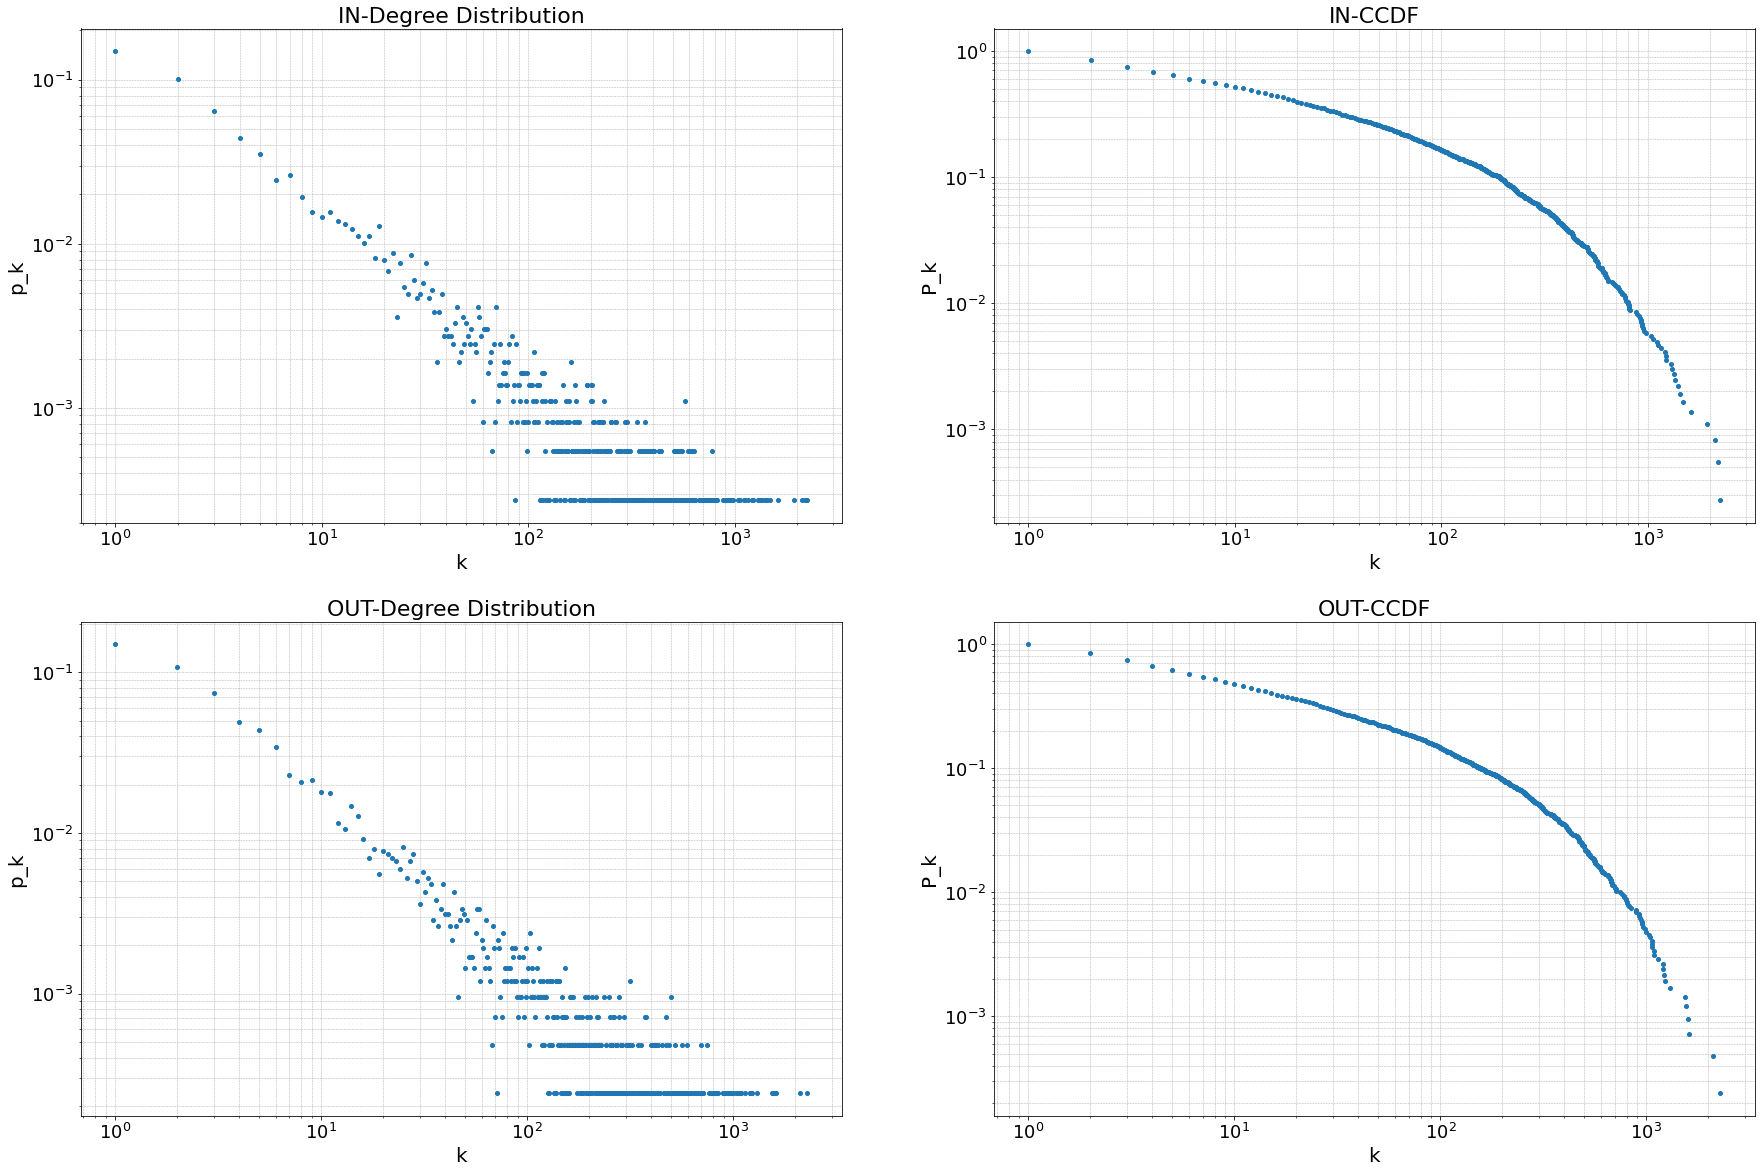

Top 10 for in degree


,Nodes,in degree
4710,UNIVERSITAT DE VALENCIA,2239
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2181
3589,UNIVERSIDADE DE LISBOA,2118
4529,UNIVERSIDAD DE GRANADA,1934
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,1615
4294,UNIVERZA V LJUBLJANI,1483
50,UNIVERSITAT POLITECNICA DE VALENCIA,1436
188,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1406
1866,UNIVERSIDAD DE SEVILLA,1352
3342,KATHOLIEKE UNIVERSITEIT LEUVEN,1340


Top 10 for out degree


,Nodes,out degree
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
4529,UNIVERSIDAD DE GRANADA,2114
4710,UNIVERSITAT DE VALENCIA,1604
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
2362,UNIVERSITA DEGLI STUDI DI PADOVA,1563
2283,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
4847,UNIVERSITA DEGLI STUDI DI TORINO,1299
3589,UNIVERSIDADE DE LISBOA,1230
3342,KATHOLIEKE UNIVERSITEIT LEUVEN,1218
4187,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1206


In [30]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

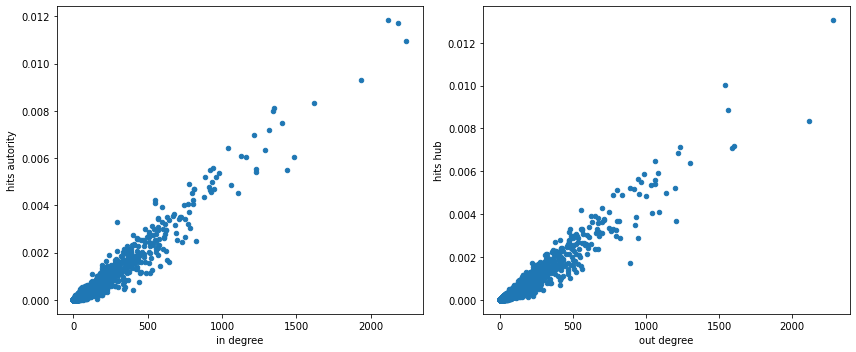

Top 10 for hits hub


,Nodes,hits hub
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013047
2283,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010031
2362,UNIVERSITA DEGLI STUDI DI PADOVA,0.008867
4529,UNIVERSIDAD DE GRANADA,0.008333
4710,UNIVERSITAT DE VALENCIA,0.007195
3589,UNIVERSIDADE DE LISBOA,0.007115
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007102
3342,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006871
4951,TECHNISCHE UNIVERSITAET MUENCHEN,0.006476
4847,UNIVERSITA DEGLI STUDI DI TORINO,0.006369


Top 10 for hits autority


,Nodes,hits autority
3589,UNIVERSIDADE DE LISBOA,0.011827
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011717
4710,UNIVERSITAT DE VALENCIA,0.010963
4529,UNIVERSIDAD DE GRANADA,0.009295
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008322
1866,UNIVERSIDAD DE SEVILLA,0.008102
3342,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007990
188,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007498
3880,UNIVERZITA KARLOVA,0.007183
4198,UNIVERSITAT DE BARCELONA,0.006963


In [31]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

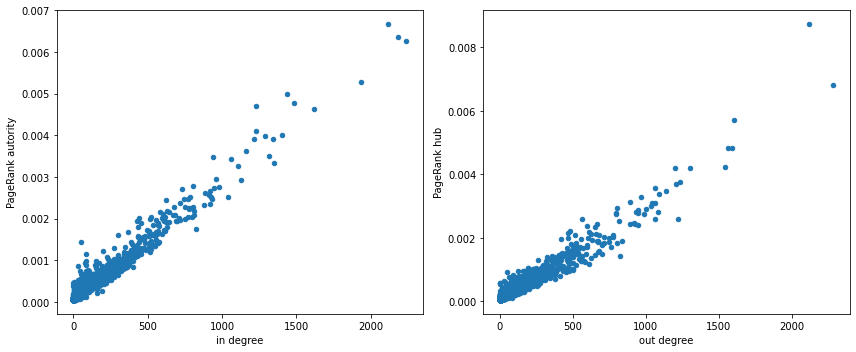

Top 10 for PageRank hub


,Nodes,PageRank hub
4529,UNIVERSIDAD DE GRANADA,0.008725
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006796
4710,UNIVERSITAT DE VALENCIA,0.005714
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004827
2362,UNIVERSITA DEGLI STUDI DI PADOVA,0.004826
2283,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004224
787,UNIVERSIDAD POLITECNICA DE MADRID,0.004187
4847,UNIVERSITA DEGLI STUDI DI TORINO,0.004185
3589,UNIVERSIDADE DE LISBOA,0.003747
4187,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.003685


Top 10 for PageRank autority


,Nodes,PageRank autority
3589,UNIVERSIDADE DE LISBOA,0.006670
4528,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006370
4710,UNIVERSITAT DE VALENCIA,0.006259
4529,UNIVERSIDAD DE GRANADA,0.005290
50,UNIVERSITAT POLITECNICA DE VALENCIA,0.004997
4294,UNIVERZA V LJUBLJANI,0.004764
501,POLITECNICO DI MILANO,0.004715
4351,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004639
2362,UNIVERSITA DEGLI STUDI DI PADOVA,0.004098
188,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.004002


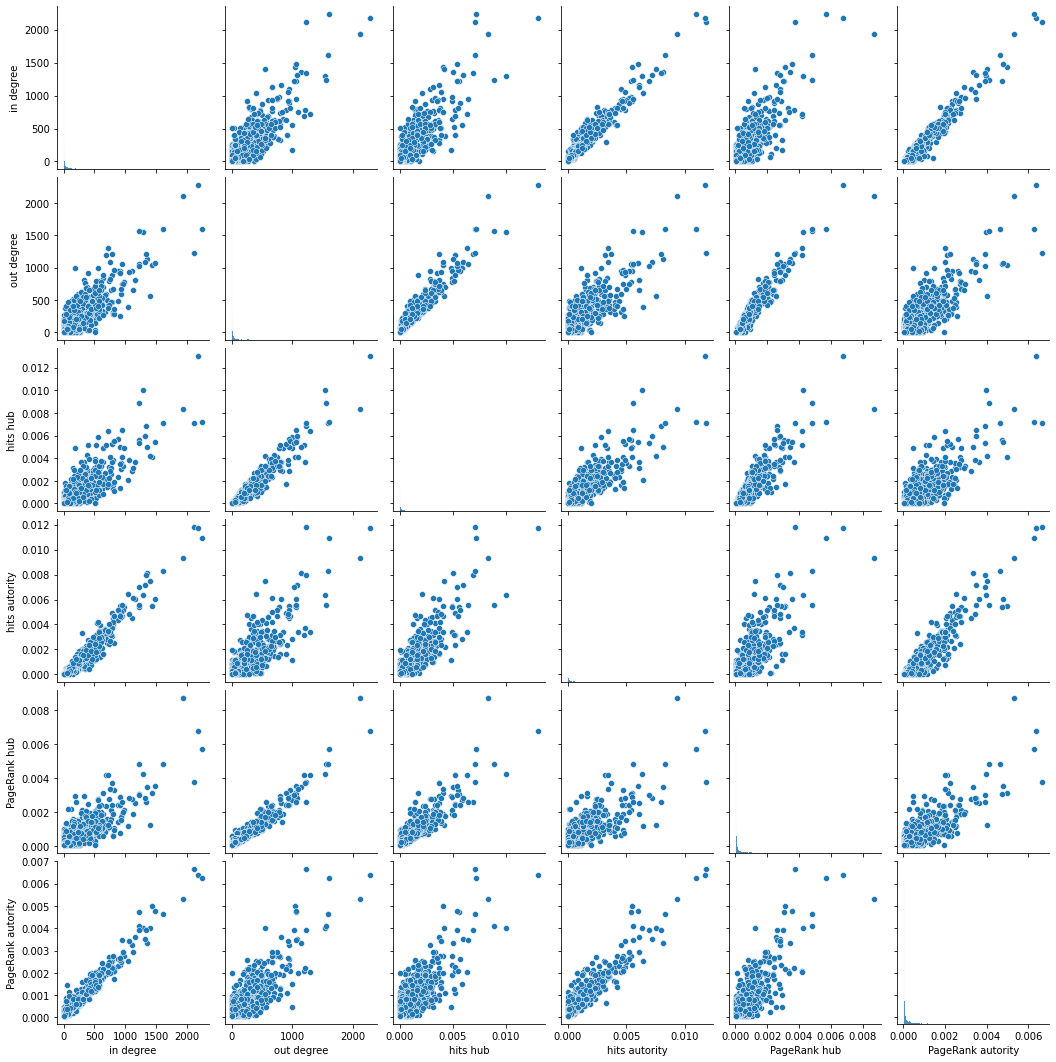

In [32]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

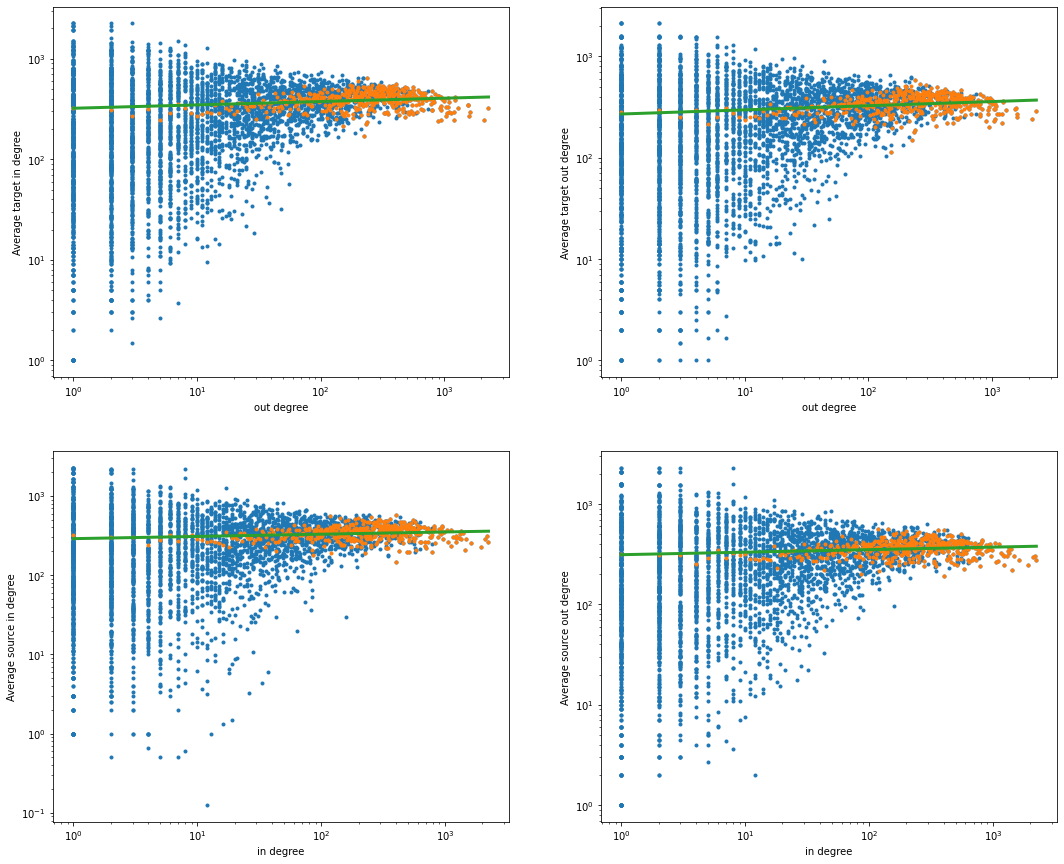

(0.03331951339261446,
 0.040916697601714264,
 0.028135364909529354,
 0.02515130462839581)

In [33]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)